In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import env 

# Wrangle

The data comes from the webserver logs of the API that we used in the timeseries module. Each row is one request to the server

In [2]:
url = env.get_connection('logs')

In [3]:
df = pd.read_sql('select * from api_access', url)
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [4]:
df.entry[0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [5]:
df.entry[0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [6]:
parts = df.entry[0].split()
parts


['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [7]:
# function to deal with parsing one entry in our log data
#this function works on one string
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [8]:
df = df.entry.apply(parse_log_entry)


In [9]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


For the sake of this lesson we will create some sythetic records and append them to our existing data frame.



In [10]:
df['size_mb'] = df['size'] / 1024 / 1024

In [11]:
df.head(2)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396


In [12]:
ip = df.ip.value_counts().rename('ip')
ip

ip
97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [14]:
ip_df1 = df.ip.value_counts().reset_index().rename(columns={'index':'ip', 'ip':'cnt'})
ip_df1


,cnt,count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,70.121.214.34,2
7,52.87.230.102,2
8,35.175.171.137,2
9,54.145.52.184,1


<Axes: >

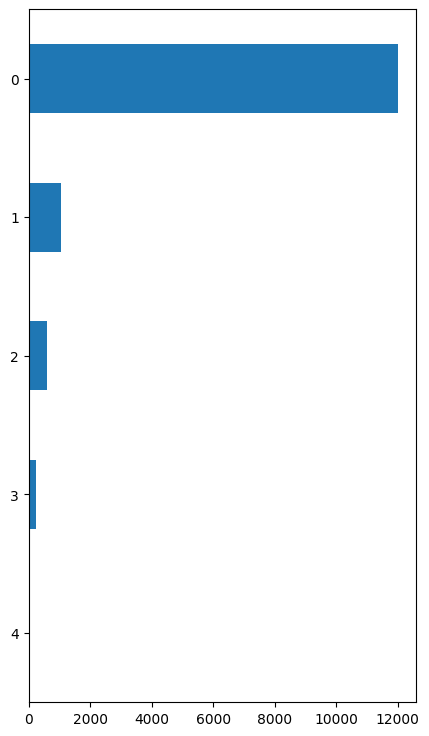

In [18]:
ip_df1['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [19]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [20]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [21]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167
